In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
import seaborn as sns
import numpy as np
import math
from string import ascii_uppercase

In [2]:
df = pd.read_csv(os.path.join("data", "human", "data_psy_estimates.csv"),
                 index_col=0)

# Select only the user that complete the task
df = df[df.n_ss_done == 14]
df

,user,domain,is_item_specific,n_ss_done,item,alpha,beta
6500,firefly@active.fi,active.fi,True,14,1404,0.003601,0.493822
8604,ladybug@active.fi,active.fi,True,14,120,0.015314,0.717256
8595,koi@active.fi,active.fi,True,14,90,0.000796,0.565144
8596,koi@active.fi,active.fi,True,14,361,0.000796,0.565144
8597,koi@active.fi,active.fi,True,14,1981,0.000796,0.565144
...,...,...,...,...,...,...,...
4487,caterpillar@active.fi,active.fi,True,14,2006,0.025000,0.736338
4486,caterpillar@active.fi,active.fi,True,14,1453,0.025000,0.736338
4485,caterpillar@active.fi,active.fi,True,14,715,0.025000,0.736338
4484,caterpillar@active.fi,active.fi,True,14,331,0.025000,0.736338


In [3]:
items = np.unique(df.item)
n_item = len(items)
n_item

2047

In [4]:
alphas_a = np.zeros(n_item)
betas_a = np.zeros(n_item)

for i, a in enumerate(items):
    df_a = df[df.item == a]
    alphas_a[i] = df_a.alpha.mean()
    betas_a[i] = df_a.beta.mean()

In [5]:
users = np.unique(df.user)
n_user = len(users)
n_user

53

In [6]:
alphas_u = np.zeros(n_user)
betas_u = np.zeros(n_user)

for i, u in enumerate(users):
    df_u = df[df.user == u]
    alphas_u[i] = np.mean(df_u.alpha.values)
    betas_u[i] = np.mean(df_u.beta.values)
# pd.DataFrame({"alpha": alphas_u, "beta": betas_u})

# Plot

In [23]:
fontsize_label = 18
fontsize_tick = 12 
fontsize_subtitle = 14
fontsize_letter = 20
fontsize_title = 18

In [8]:
def joint_plot(alpha_values, beta_values, color="C1"):
    
    # BOUNDS = [[2e-07, 0.025], [0.0001, 0.9999]]
    
    g = sns.jointplot(x=beta_values, y=np.log(alpha_values),
                     joint_kws = dict(alpha=0.5,), color=color)
    ax = g.ax_joint

    ax.set_yticks(np.log([2e-07, 5.19e-05, 0.025]))
    ax.set_ylim(np.log([2e-07, 0.028]))
    ax.set_yticks(np.log([2e-07, 5.19e-05, 0.025]))
    ax.set_yticklabels(("2e-07", "5.19e-05", "0.025"), fontsize=fontsize_tick)

    ax.set_xlabel(r"$\beta$", fontsize=fontsize_label)
    ax.set_ylabel(r"$\alpha$", fontsize=fontsize_label)

    ax.set_xticks((0, 0.5, 1.0))
    ax.set_xlim(0, 1)
    ax.xaxis.set_tick_params(labelsize=fontsize_tick)
    
    return g

In [9]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        # https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

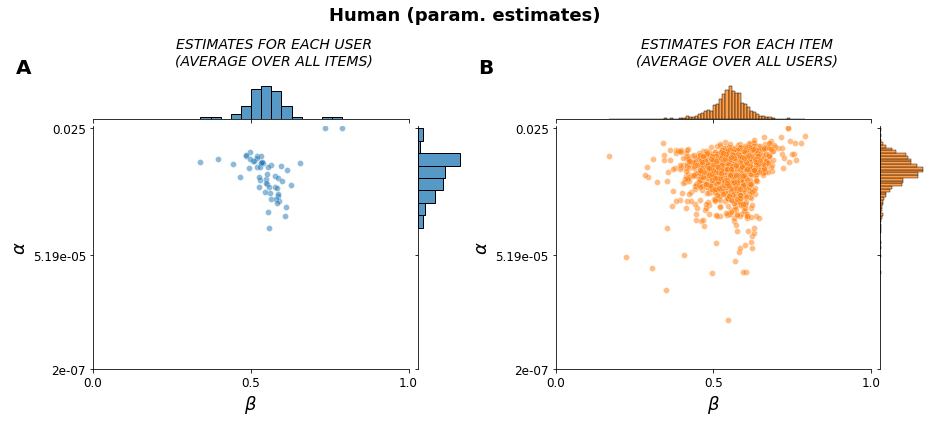

In [25]:
g0 = joint_plot(alpha_values=alphas_u, beta_values=betas_u, color="C0")
g1 = joint_plot(alpha_values=alphas_a, beta_values=betas_a, color="C1")

subtitle0 = "Estimates for each user\n(average over all items)"
subtitle1 = "Estimates for each item\n(average over all users)"

fig = plt.figure(figsize=(13,6))
gs = gridspec.GridSpec(2, 2, height_ratios=[0.02, 0.98])

fig.suptitle("Human (param. estimates)",
             fontweight="bold",
             fontsize=fontsize_title)

mg0 = SeabornFig2Grid(g0, fig, gs[1,0])
mg1 = SeabornFig2Grid(g1, fig, gs[1, 1])


ax = fig.add_subplot(gs[0, 0])
ax.set_axis_off()
ax.set_title(subtitle0.upper(), fontsize=fontsize_subtitle, ha='center', fontstyle='italic')
ax.text(-0.2, 0.5, "A", transform=ax.transAxes, size=fontsize_letter, weight='bold')

ax = fig.add_subplot(gs[0, 1])
ax.set_axis_off()
ax.set_title(subtitle1.upper(), fontsize=fontsize_subtitle, ha='center', fontstyle='italic')
ax.text(-0.2, 0.5, "B", transform=ax.transAxes, size=fontsize_letter, weight='bold')

gs.tight_layout(fig)
# gs.update(top=0.7)

plt.savefig("fig/fig5.pdf")

# Statistics

In [13]:
stats.sem(alphas_u), stats.sem(betas_u)

(0.0006418608478792965, 0.00950816473897002)

In [14]:
stats.sem(alphas_a), stats.sem(betas_a)

(5.4748242006237056e-05, 0.0013006531618877967)

In [15]:
np.std(alphas_u), np.std(betas_u)

(0.004628524397483191, 0.06856435100383017)

In [16]:
np.std(alphas_a), np.std(betas_a)

(0.002476412531399924, 0.05883209526137725)